# Machine Learning: Customer Segmentation for Product Optimization

### This project is for the partial requirements for the fulfilment of the course CPE16 - Introduction to AI
Created by Group 1 CPE126_C1 4Q AY 2021-2022
#### Atanacio | Ilano | Jintalan | Yango

### To access the document, go to

https://github.com/garchompers08/CPE126C1_G1_MP.git

### Project Brief Description
Customer Segmentation for Product Optimization is a project based on python which aims to create an AI which predicts the sample’s potential as market. This project aims to help the small medium enterprises of the target partnered community of Mapua University by optimising the data collected in the community and using it as a tool to enhance their products and business. By doing so, businesses can focus on specific products and services that will be successful based on the data produced by our AI.


## Load Dependencies and Configuration Settings

In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

%matplotlib inline

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from mpl_toolkits.mplot3d import Axes3D

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *

In [18]:
cs_df = pd.read_excel(io=r'Online Retail.xlsx')

In [19]:
cs_df.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

* **InvoiceNo**: A unique identifier for the invoice. An invoice number shared across rows means that those transactions were performed in a single invoice (multiple purchases).
* **StockCode**: Identifier for items contained in an invoice.
* **Description**: Textual description of each of the stock item.
* **Quantity**: The quantity of the item purchased.
* **InvoiceDate**: Date of purchase.
* **UnitPrice**: Value of each item.
* **CustomerID**: Identifier for customer making the purchase.
* **Country**: Country of customer.

In [20]:
# Remove register withou CustomerID
cs_df = cs_df[~(cs_df.CustomerID.isnull())]

# Remove negative or return transactions
cs_df = cs_df[~(cs_df.Quantity<0)]
cs_df = cs_df[cs_df.UnitPrice>0]



In [21]:
cat_des_df = cs_df.groupby(["StockCode","Description"]).count().reset_index()
display(cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index().head())
cs_df[cs_df['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1]
      .reset_index()['index'][4]]['Description'].unique()

index  StockCode
0   23196          4
1   23236          4
2   23203          3
3  17107D          3
4   23535          3

array(['BICYCLE SAFTEY WALL ART', 'WALL ART BICYCLE SAFTEY ',
       'WALL ART BICYCLE SAFETY'], dtype=object)

In [22]:
unique_desc = cs_df[["StockCode", "Description"]].groupby(by=["StockCode"]).\
                apply(pd.DataFrame.mode).reset_index(drop=True)
q = '''
select df.InvoiceNo, df.StockCode, un.Description, df.Quantity, df.InvoiceDate,
       df.UnitPrice, df.CustomerID, df.Country
from cs_df as df INNER JOIN 
     unique_desc as un on df.StockCode = un.StockCode
'''

cs_df = pysqldf(q)

In [23]:
cs_df.InvoiceDate = pd.to_datetime(cs_df.InvoiceDate)
cs_df['amount'] = cs_df.Quantity*cs_df.UnitPrice
cs_df.CustomerID = cs_df.CustomerID.astype('float32')


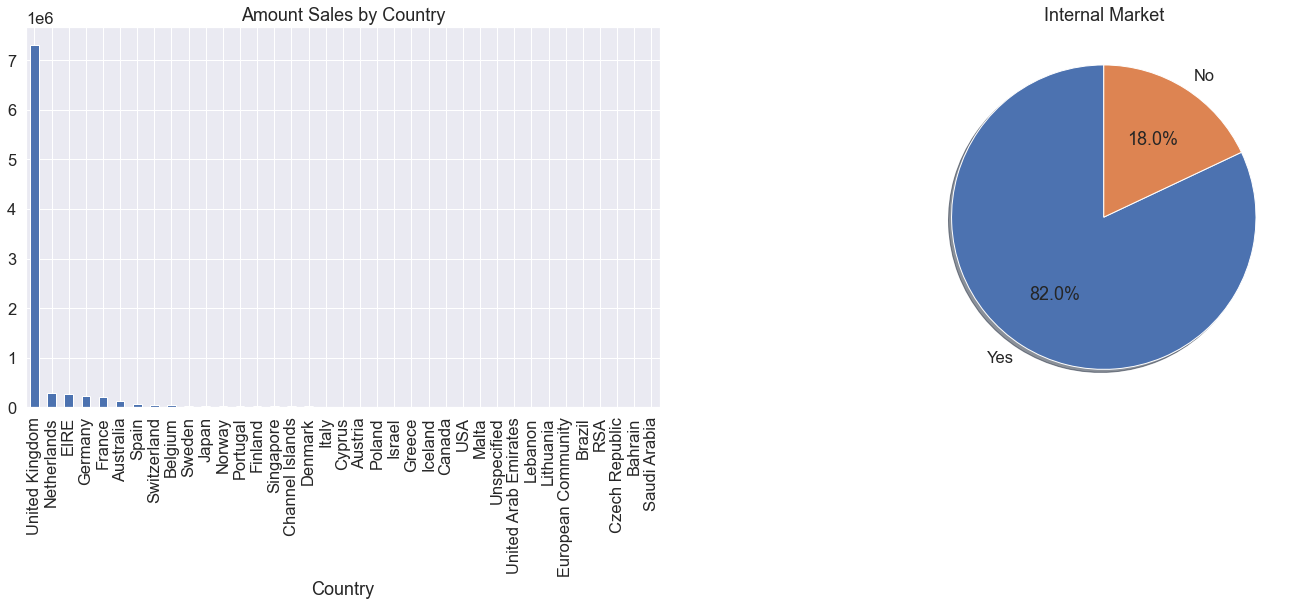

In [12]:
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
g = cs_df.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')
cs_df['Internal'] = cs_df.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No' )
f2 = fig.add_subplot(122)
market = cs_df.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Internal Market')
plt.show()

In [69]:
fig = plt.figure(figsize=(25, 7))
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amont'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((cs_df.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(["CustomerID"]).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))

KeyError: 51

<Figure size 1800x504 with 0 Axes>

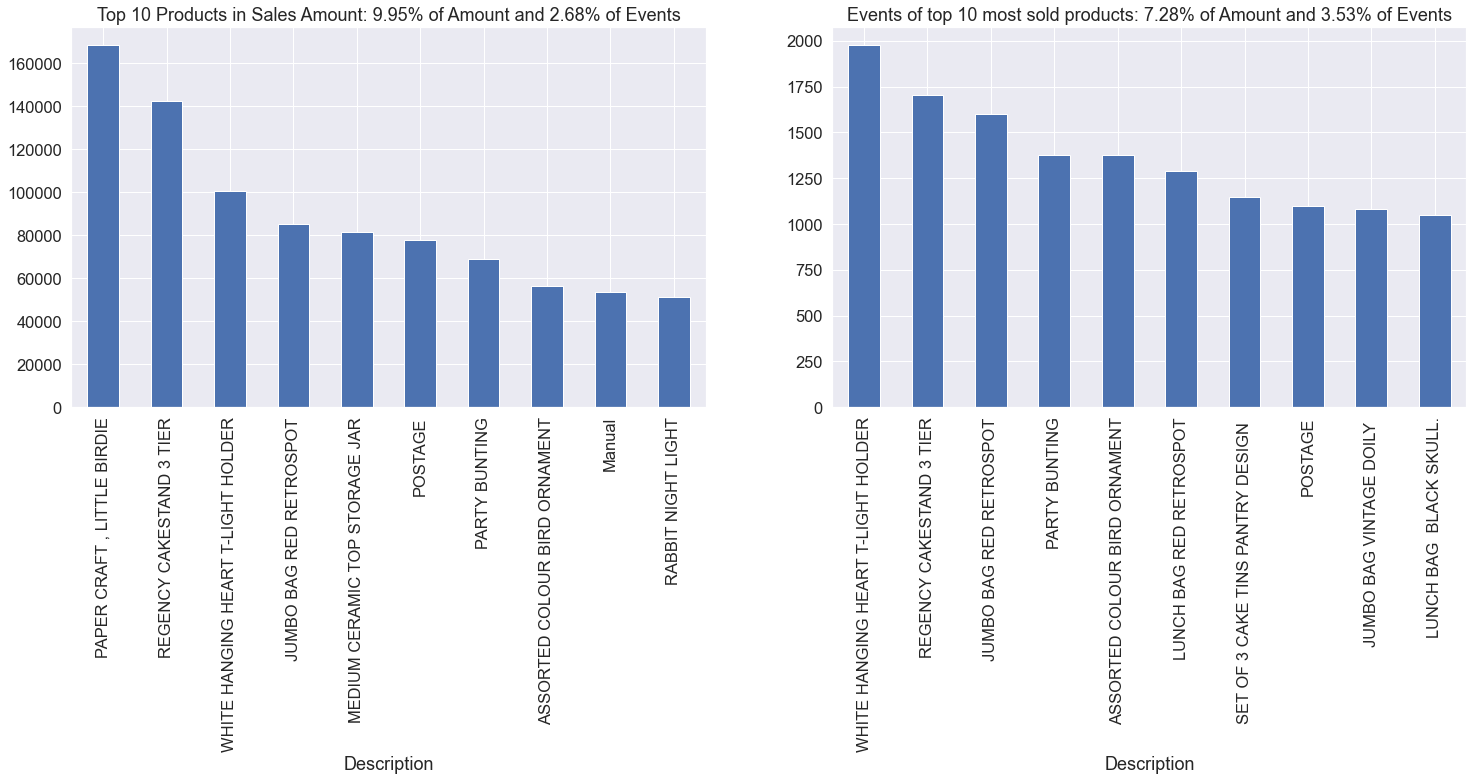

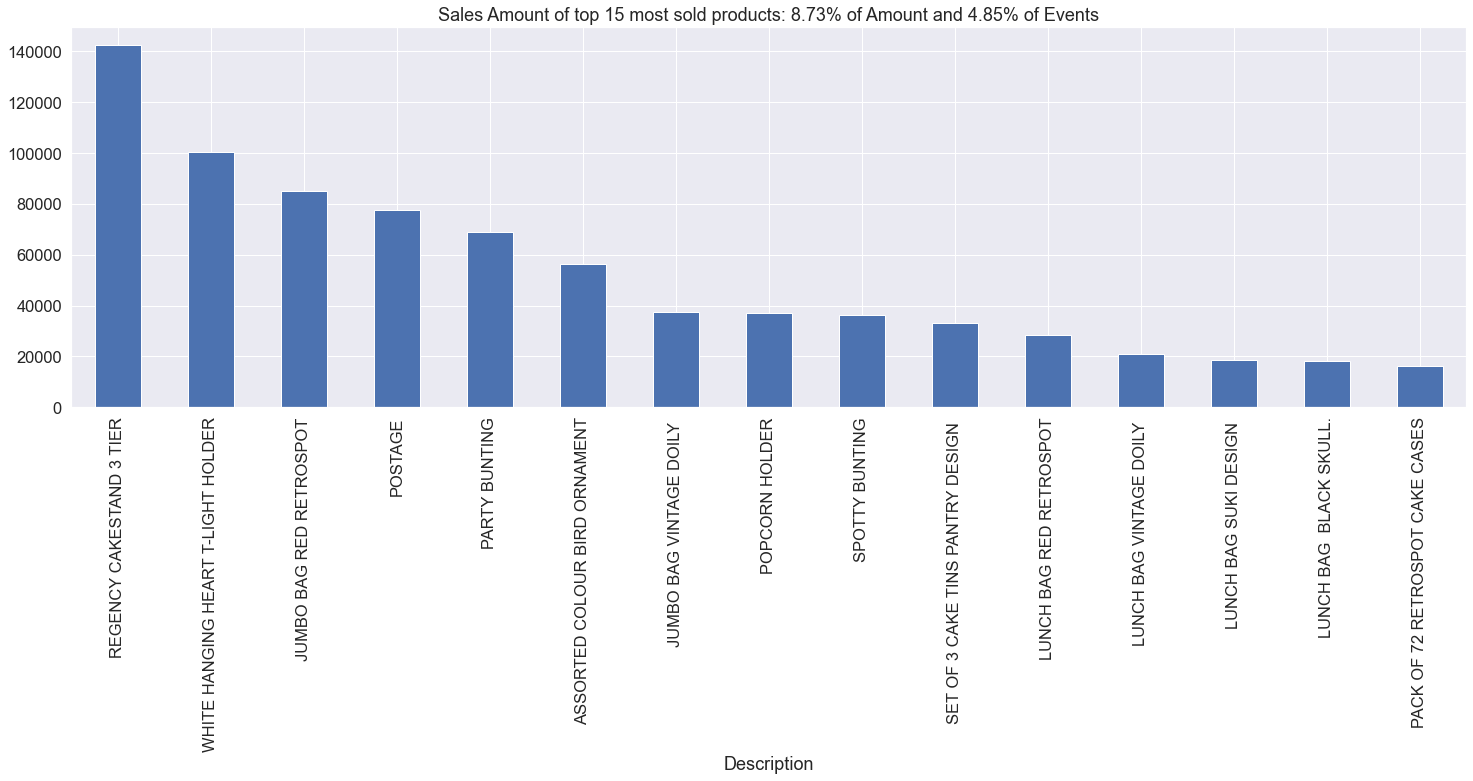

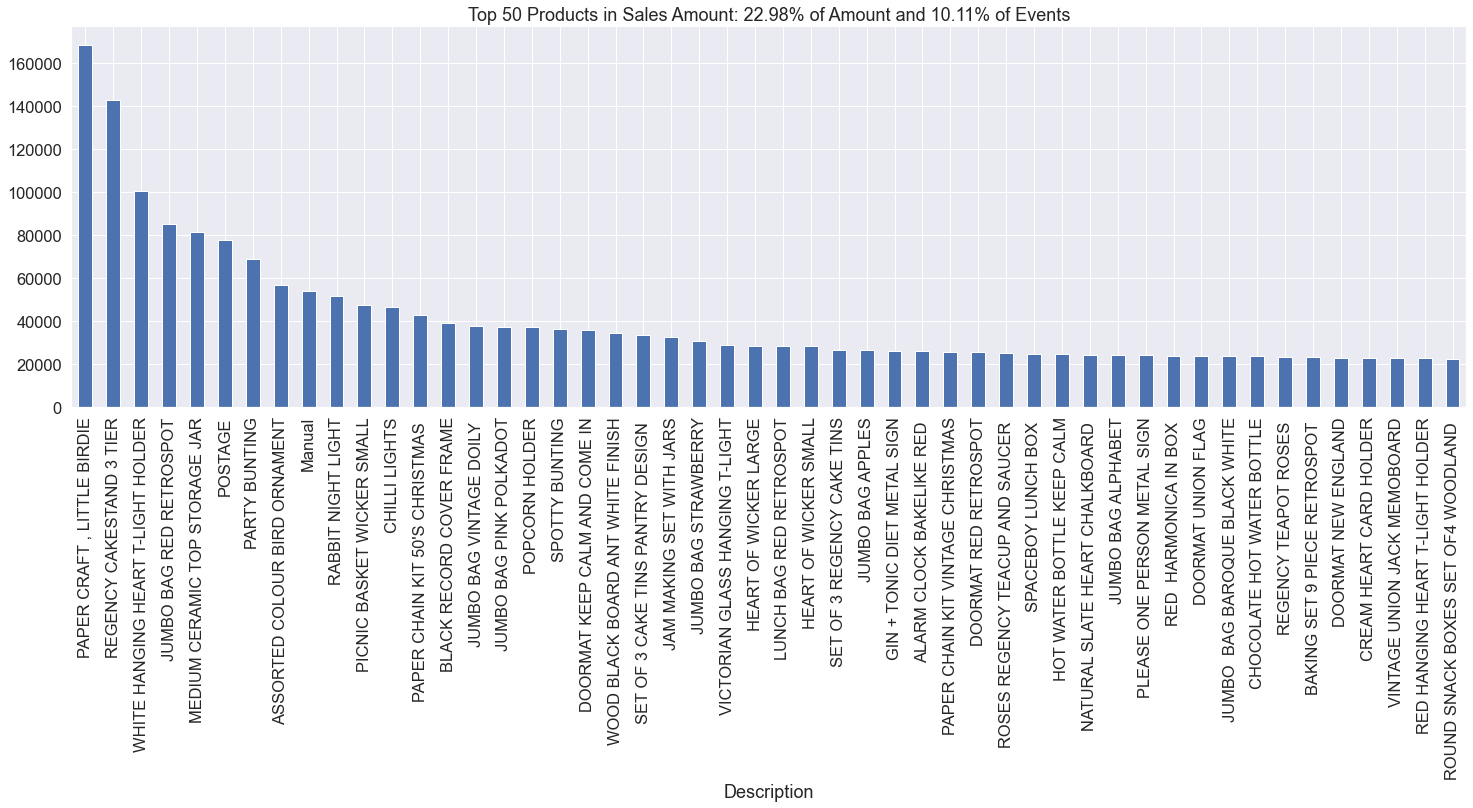

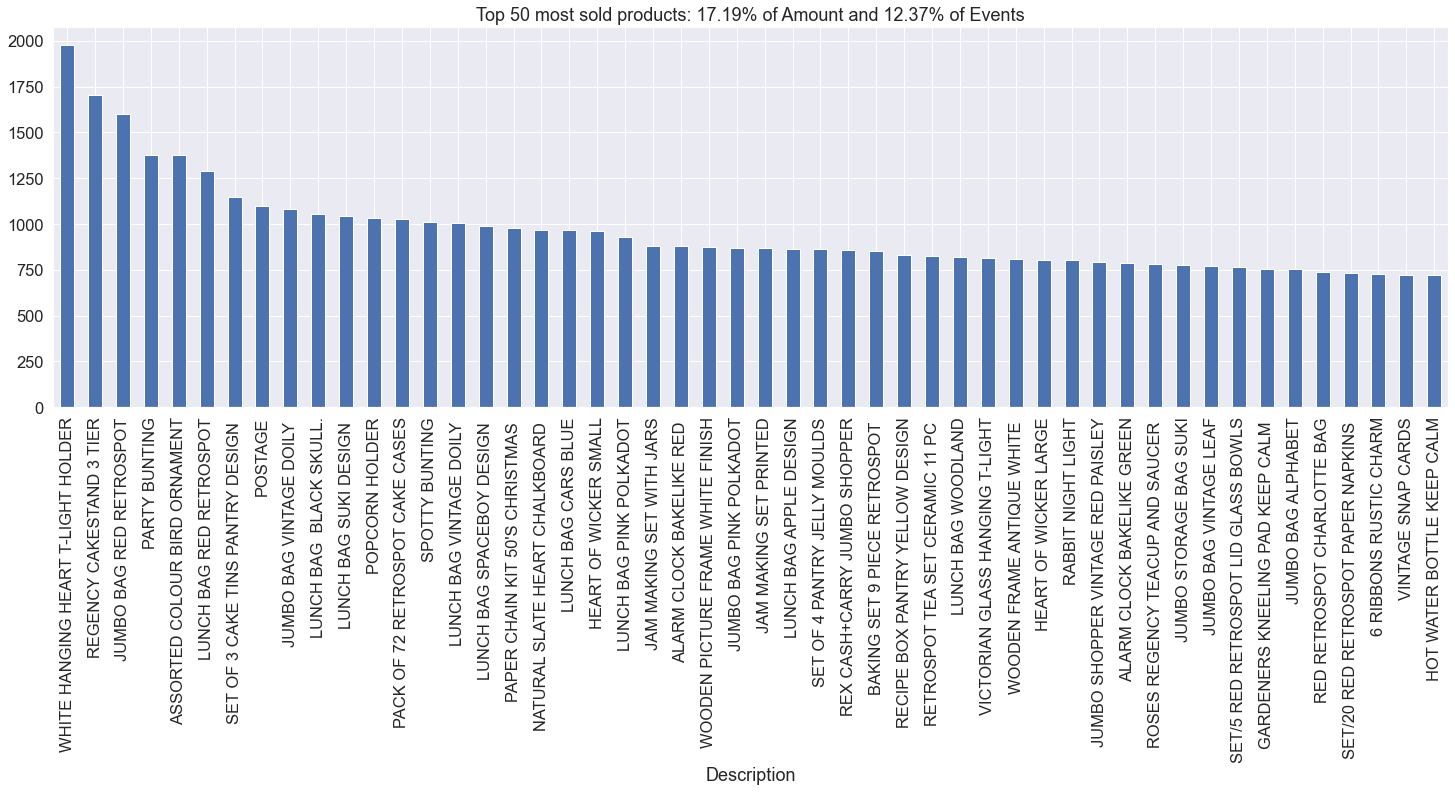

In [50]:
AmoutSum = cs_df.groupby(["Description"]).amount.sum().sort_values(ascending = False)
inv = cs_df[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
      agg(np.size).sort_values(ascending = False)

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
Top10 = list(AmoutSum[:10].index)
PercentSales =  np.round((AmoutSum[Top10].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top10].\
    plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))
f1 = fig.add_subplot(122)
Top10Ev = list(inv[:10].index)
PercentSales =  np.round((AmoutSum[Top10Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


fig = plt.figure(figsize=(25, 7))
Top15ev = list(inv[:15].index)
PercentSales =  np.round((AmoutSum[Top15ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15ev].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top15ev].sort_values(ascending = False).\
    plot(kind='bar', 
         title='Sales Amount of top 15 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50 = list(AmoutSum[:50].index)
PercentSales =  np.round((AmoutSum[Top50].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top50].\
    plot(kind='bar', 
         title='Top 50 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50Ev = list(inv[:50].index)
PercentSales =  np.round((AmoutSum[Top50Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top50Ev].\
    plot(kind='bar', title='Top 50 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))



# Customer Segmentation

#### Recency
To create the recency feature variable, we need to decide the reference date for our analysis. Usually, we make use of the last transaction date plus one day. Then, we will construct the recency variable as the number of days before the reference date when a customer last made a purchase.

In [11]:
refrence_date = cs_df.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
cs_df['days_since_last_purchase'] = (refrence_date - cs_df.InvoiceDate).astype('timedelta64[D]')
customer_history_df =  cs_df[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00


count          mean          std      min       25%      50%  \
CustomerID  4338.0  15300.408022  1721.808492  12346.0  13813.25  15299.5   
recency     4338.0     92.536422   100.014169      1.0     18.00     51.0   

                 75%      max  
CustomerID  16778.75  18287.0  
recency       142.00    374.0

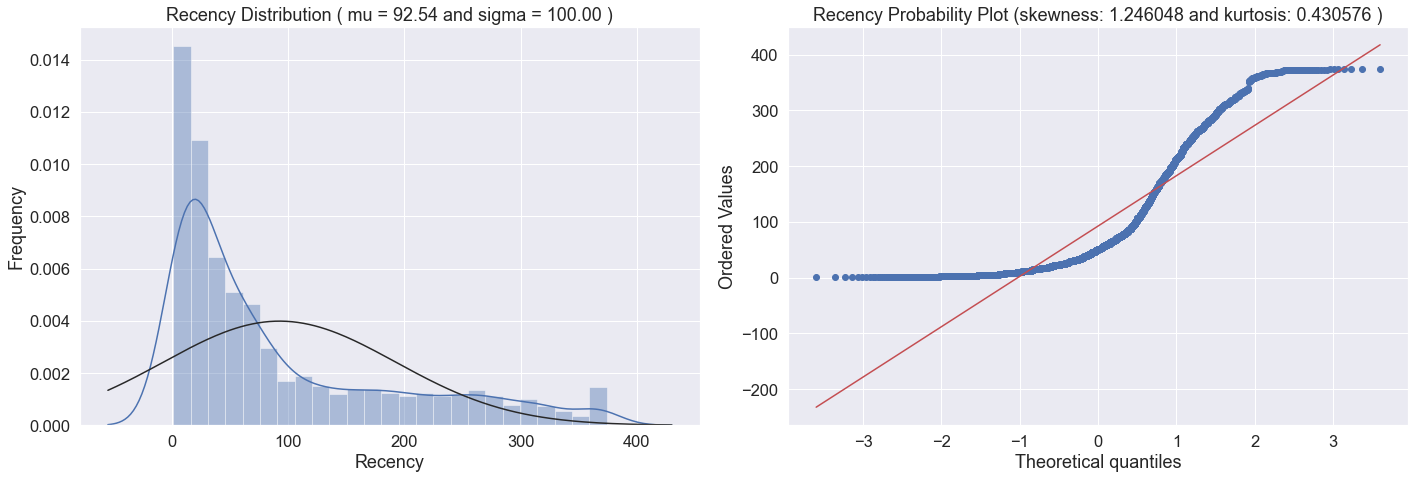

In [25]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history_df.recency, 'Recency')

From the first graph above we can see that sales recency distribution is ***skewed***, has a **peak** on the left and a long tail to the right. It **deviates from normal distribution** and is **positively biased**.

From the **Probability Plot**, we could see that **sales recency** also does **not align with the diagonal  <span style="color:red">red line</span>** which represent normal distribution. The form of its distribution confirm that is a skewed right. 

With ***skewness positive of 1.25***, we confirm the **lack of symmetry** and indicate that sales recency  are **skewed right**, as we can see too at the Sales Distribution plot, skewed right means that the right tail is **long relative to the left tail**. The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

**Kurtosis** is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers, and **positive** kurtosis indicates a **heavy-tailed distribution** and **negative** kurtosis indicates a **light tailed distribution**. So, with 0.43 of positive kurtosis **sales recency** are heavy-tailed and has some **outliers**.

#### Frequency


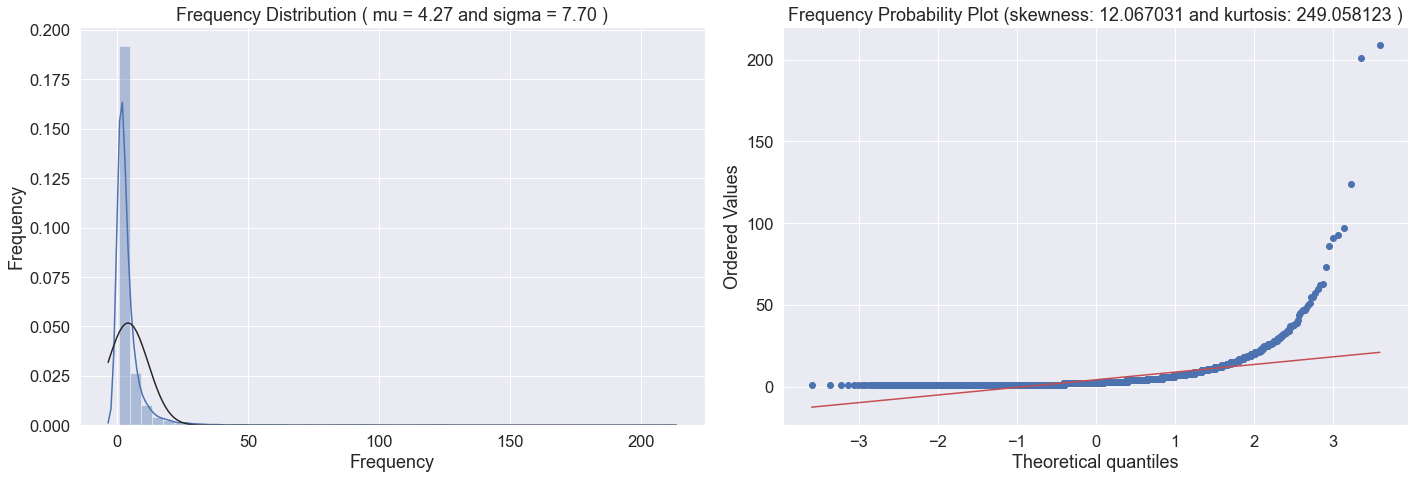

In [32]:
customer_freq = (cs_df[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')

From the first graph above we can see that sales frequency distribution is ***skewed***, has a **peak** on the left and a long tail to the right. It **deviates from normal distribution** and is **positively biased**.

From the **Probability Plot**, we could see that **sales frequency** also does **not align with the diagonal and confirm that is a skewed right. 

With ***skewness positive of 12.1***, we confirm the **high lack of symmetry** and with 249 **Kurtosis** indicates that is a **heavy-tailed distribution** and has **outliers**.

#### Monetary Value

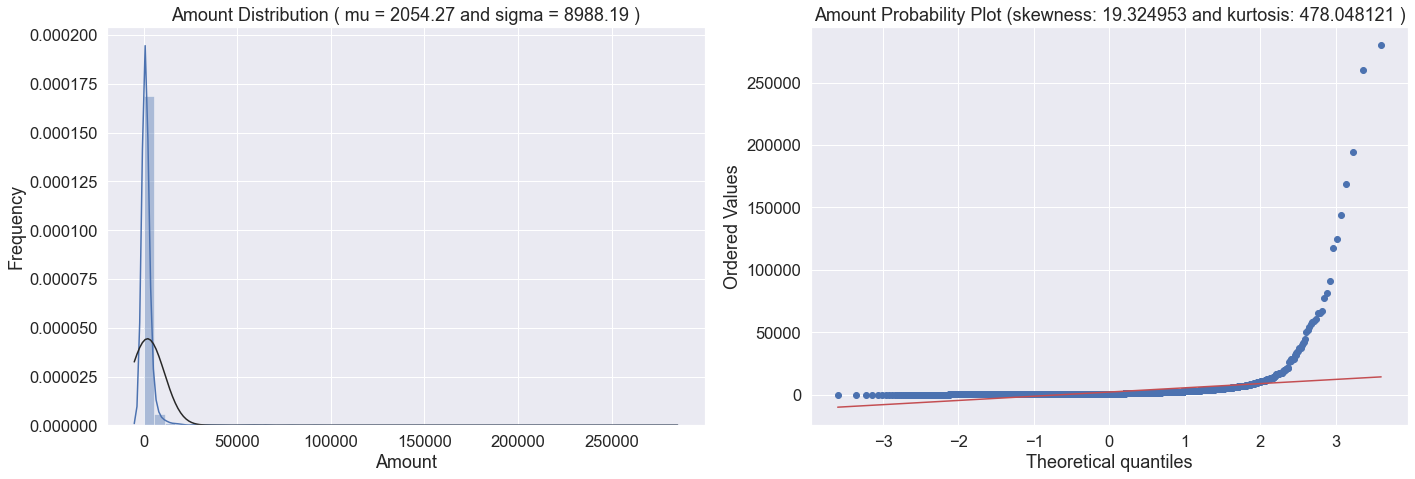

In [33]:
customer_monetary_val = cs_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
QQ_plot(customer_history_df.amount, 'Amount')

In [34]:
customer_history_df.describe()

CustomerID      recency  recency_log    frequency         amount
count   4338.000000  4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     3.767534     4.272015    2054.266460
std     1721.808492   100.014169     1.432445     7.697998    8989.230441
min    12346.000000     1.000000     0.000000     1.000000       3.750000
25%    13813.250000    18.000000     2.890372     1.000000     307.415000
50%    15299.500000    51.000000     3.931826     2.000000     674.485000
75%    16778.750000   142.000000     4.955827     5.000000    1661.740000
max    18287.000000   374.000000     5.924256   209.000000  280206.020000

### Data Preprocessing

In [59]:
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

count          mean       std       min       25%       50%  \
amount_log     4338.0 -8.022628e-16  1.000115 -4.179280 -0.684183 -0.060942   
recency_log    4338.0 -1.027980e-16  1.000115 -2.630445 -0.612424  0.114707   
frequency_log  4338.0 -2.355833e-16  1.000115 -1.048610 -1.048610 -0.279044   

                    75%       max  
amount_log     0.654244  4.721395  
recency_log    0.829652  1.505796  
frequency_log  0.738267  4.882714

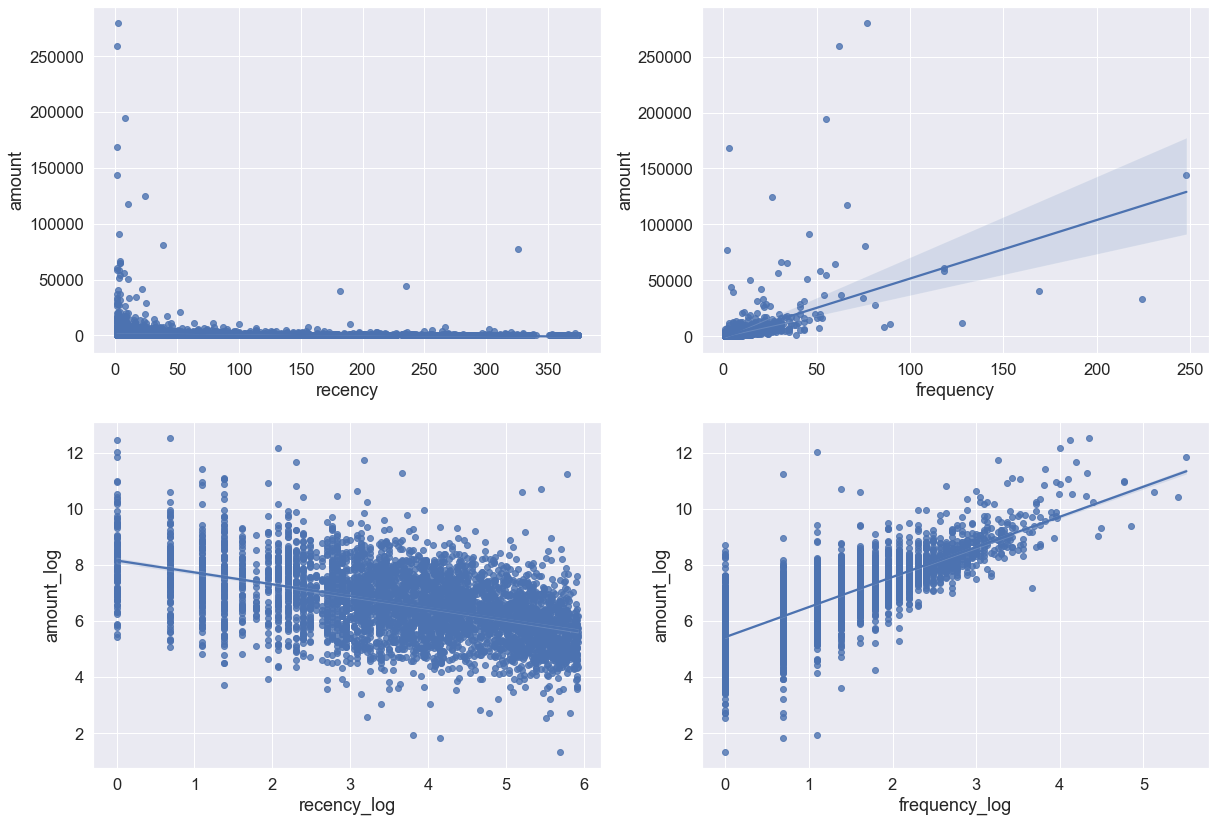

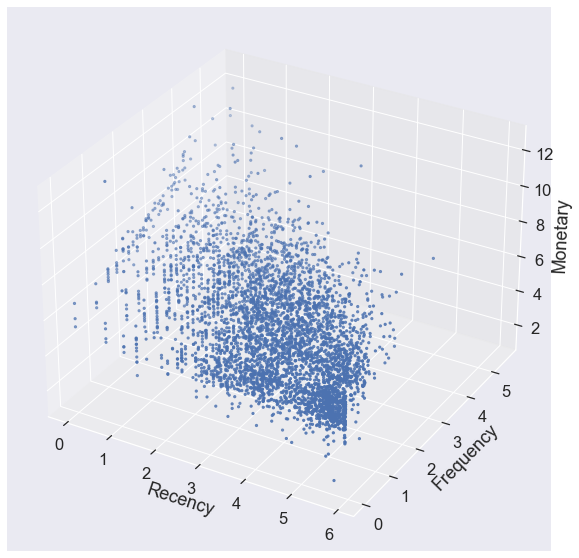

In [34]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=customer_history_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=customer_history_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

### Clustering for Segments
#### K-Means Clustering 

Based on this Euclidean distance metric, we can describe the k-means algorithm as a simple optimization problem, an iterative approach for minimizing the within-cluster sum of squared errors (SSE), which is sometimes also called cluster inertia. So, the objective of K-Means clustering is to minimize total intra-cluster variance, or, the squared error function: 
![image](https://www.saedsayad.com/images/Clustering_kmeans_c.png)

#### The Elbow Method
  
Using the elbow method to find the optimal number of clusters. The idea behind the elbow method is to identify the value of k where the distortion begins to increase most rapidly. If k increases, the distortion will decrease, because the samples will be closer to the centroids they are assigned to. 

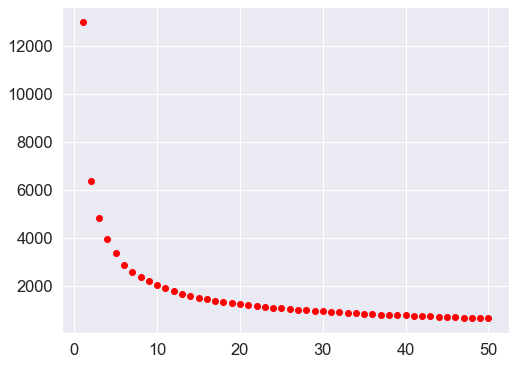

The best K sugest:  7


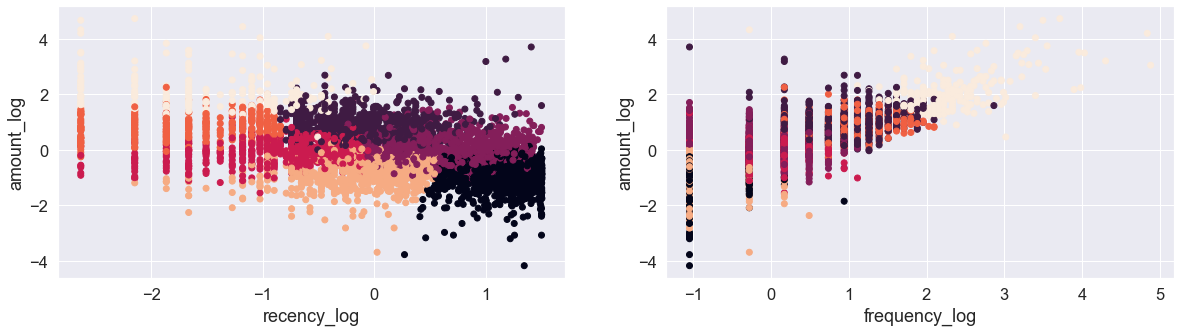

In [36]:
cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()

#### Silhouette analysis on K-Means clustering

Silhouette analysis can be used to study the separation distance between the resulting clusters, as a strategy to quantifying the quality of clustering via graphical tool to plot a measure of how tightly grouped the samples in the clusters are. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. 

It can also be applied to clustering algorithms other than k-means

Silhouette coefficients has a range of \[-1, 1\], it calculated by:
1. Calculate the cluster cohesion a( i )as the average distance between a sample x( i )   and all other points in the same cluster.
2. Calculate the cluster separation b( i ) from the next closest cluster as the average distance between the sample x( i ) and all samples in the nearest cluster.
3. Calculate the silhouette s( i )  as the difference between cluster cohesion and separation divided by the greater of the two, as shown here:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/3d80ab22fb291b347b2d9dc3cc7cd614f6b15479)
Which can be also written as:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/ab5579a6c7150579af8a0d432b6630ba529376f0)

Where:
- If near +1, it indicate that the sample is far away from the neighboring clusters. 
- a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. 
- If most objects have a high value, then the clustering configuration is appropriate. 
- If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
- A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters
- Negative values indicate that those samples might have been assigned to the wrong cluster.

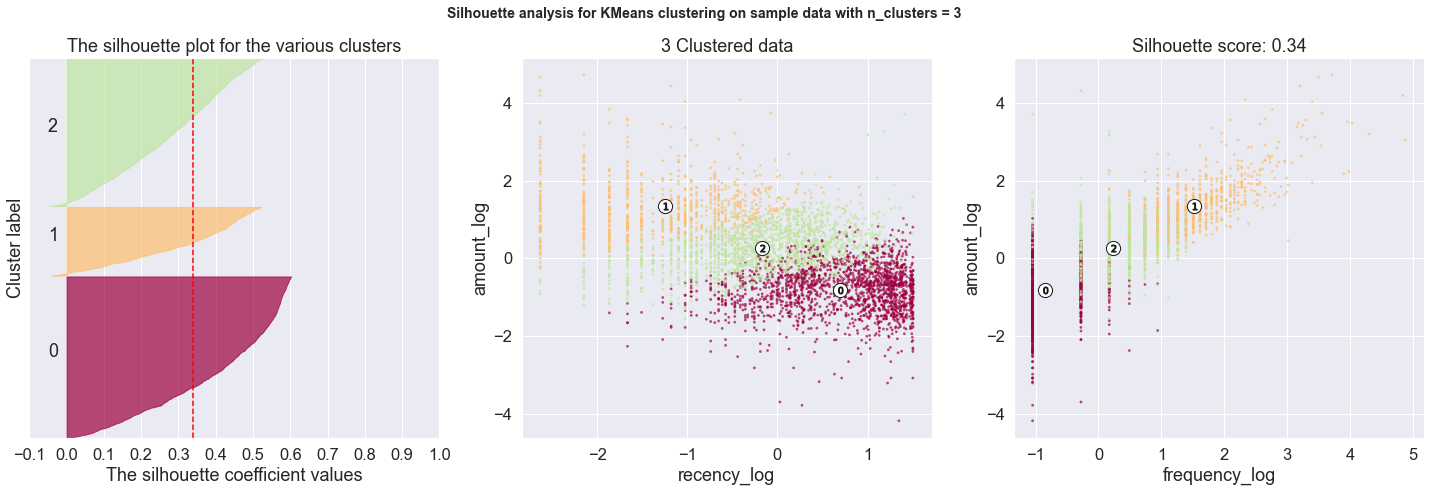

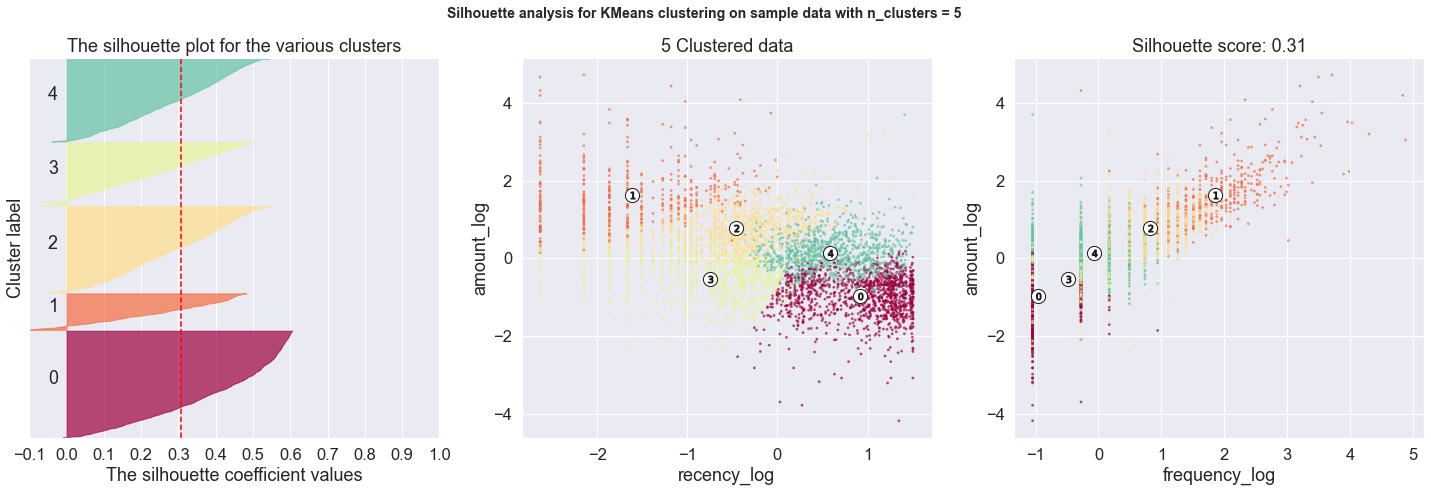

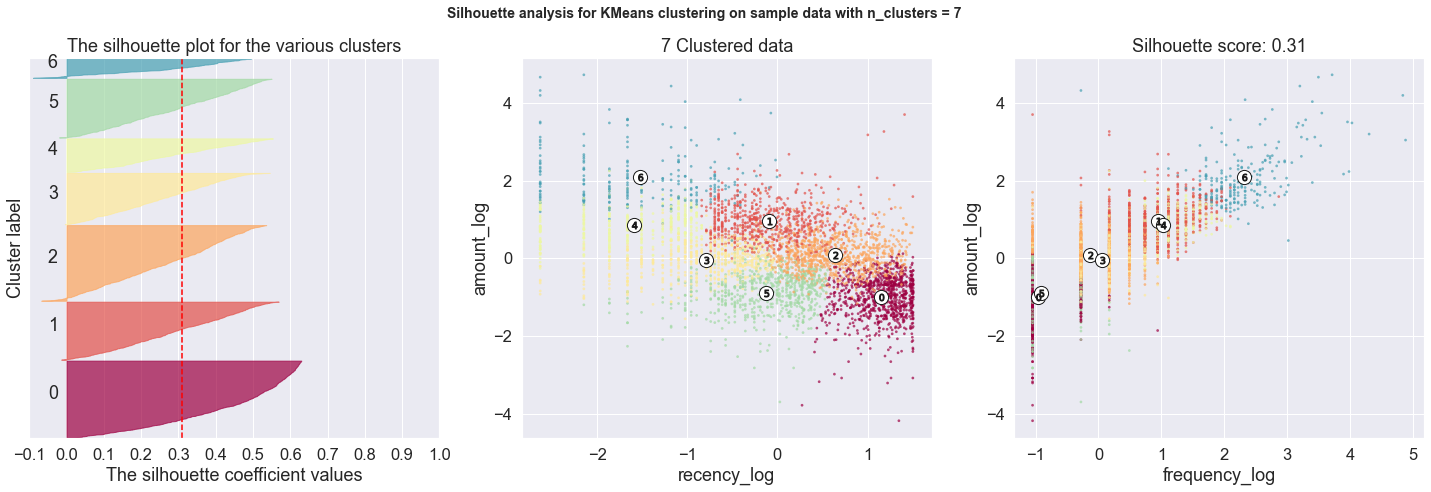

In [37]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1,2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

#### Clusters Center:

In [38]:
features = ['amount',  'recency',  'frequency']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Centers of each cluster:
        amount     recency  frequency
0   261.952265  116.604917   1.190876
1  3967.994380    7.236580  10.044493
2  1006.914317   33.819966   3.152227
--------------------------------------------------
for 5 clusters the silhouette score is 0.31
Centers of each cluster:
        amount     recency  frequency
0   213.438964  160.737849   1.088263
1  5708.668108    4.285608  13.677542
2  1930.204520   22.348243   5.414660
3   369.930740   14.854813   1.649874
4   863.647685   99.752358   2.401419
--------------------------------------------------
for 7 clusters the silhouette score is 0.31
Centers of each cluster:
         amount     recency  frequency
0    205.257565  225.386840   1.083954
1   2447.431580   38.058360   6.037971
2    810.639899  107.621358   2.278104
3    678.481625   13.838593   2.689984
4   2123.643873    4.419742   6.441601
5    240.091620   36.207714   1.134226
6  10213.306074    4.904358  20.795906

#### Clusters Insights:

[insert cluster insights here]

CustomerID  recency  recency_log  frequency    amount  frequency_log  \
0     12346.0    326.0     5.786897          1  77183.60       0.000000   
1     12347.0      2.0     0.693147          7   4310.00       1.945910   
2     12348.0     75.0     4.317488          4   1797.24       1.386294   
3     12349.0     19.0     2.944439          1   1757.55       0.000000   
4     12350.0    310.0     5.736572          1    334.40       0.000000   

   amount_log  clusters_3  clusters_5  
0   11.253942           2           4  
1    8.368693           1           1  
2    7.494007           2           4  
3    7.471676           2           3  
4    5.812338           0           0

AttributeError: 'DataFrame' object has no attribute 'clusters_7'

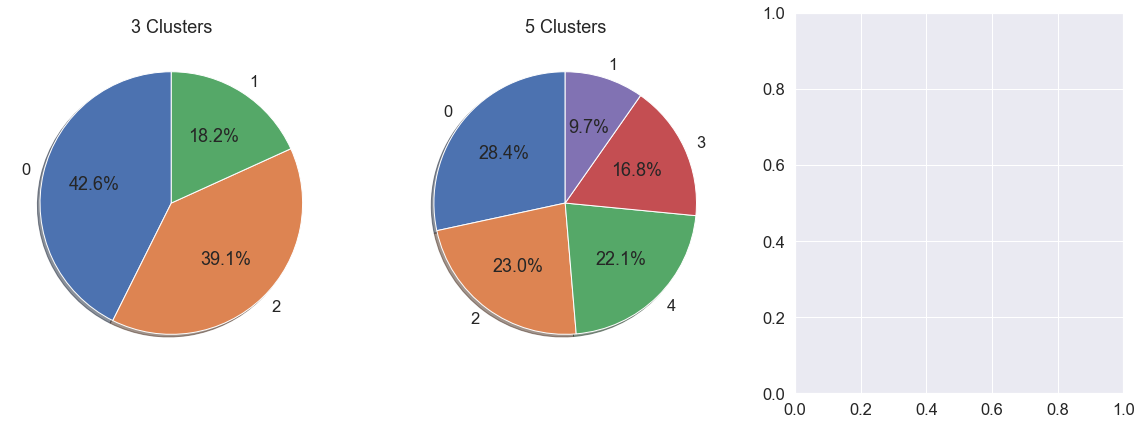

In [42]:
customer_history_df['clusters_3'] = cluster_centers[3]['labels'] 
customer_history_df['clusters_5'] = cluster_centers[5]['labels']
#customer_history_df['clusters_7'] = cluster_centers[7]['labels']
display(customer_history_df.head())

fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = customer_history_df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')
f1 = fig.add_subplot(132)
market = customer_history_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')
f1 = fig.add_subplot(133)
market = customer_history_df.clusters_7.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('7 Clusters')
plt.show()

In [43]:
x_data = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
cutoff_quantile = 95

for n_clusters in range(3,K_best+1,2):
    cl = 'clusters_' + str(n_clusters)
    for fild in range(0, 3):
        field_to_plot = features[fild]        
        y_data = list()
        ymax = 0
        for i in np.arange(0,n_clusters):
            y0 = customer_history_df[customer_history_df[cl]==i][field_to_plot].values
            y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
            if ymax < max(y0): ymax = max(y0)
            y_data.insert(i, y0)

        traces = []

        for xd, yd, cls in zip(x_data[:n_clusters], y_data, colors[:n_clusters]):
                traces.append(go.Box(y=yd, name=xd, boxpoints=False, jitter=0.5, whiskerwidth=0.2, fillcolor=cls,
                    marker=dict( size=1, ),
                    line=dict(width=1),
                ))

        layout = go.Layout(
            title='Difference in {} with {} Clusters and {:1.2f} Score'.\
            format(field_to_plot, n_clusters, cluster_centers[n_clusters]['silhouette_score']),
            yaxis=dict( autorange=True, showgrid=True, zeroline=True,
                dtick = int(ymax/10),
                gridcolor='black', gridwidth=0.1, zerolinecolor='rgb(255, 255, 255)', zerolinewidth=2, ),
            margin=dict(l=40, r=30, b=50, t=50, ),
            paper_bgcolor='white',
            plot_bgcolor='white',
            showlegend=False
        )

        fig = go.Figure(data=traces, layout=layout)
        py.offline.iplot(fig)

KeyError: 'clusters_7'

#### Drill Down Clusters:

CustomerID  recency  recency_log  frequency    amount  frequency_log  \
0     12346.0    326.0     5.786897          1  77183.60       0.000000   
1     12347.0      2.0     0.693147          7   4310.00       1.945910   
2     12348.0     75.0     4.317488          4   1797.24       1.386294   
3     12349.0     19.0     2.944439          1   1757.55       0.000000   
4     12350.0    310.0     5.736572          1    334.40       0.000000   

   amount_log  clusters_3  clusters_5  clusters_7  
0   11.253942           2           4           1  
1    8.368693           1           1           4  
2    7.494007           2           4           1  
3    7.471676           2           3           3  
4    5.812338           0           0           0

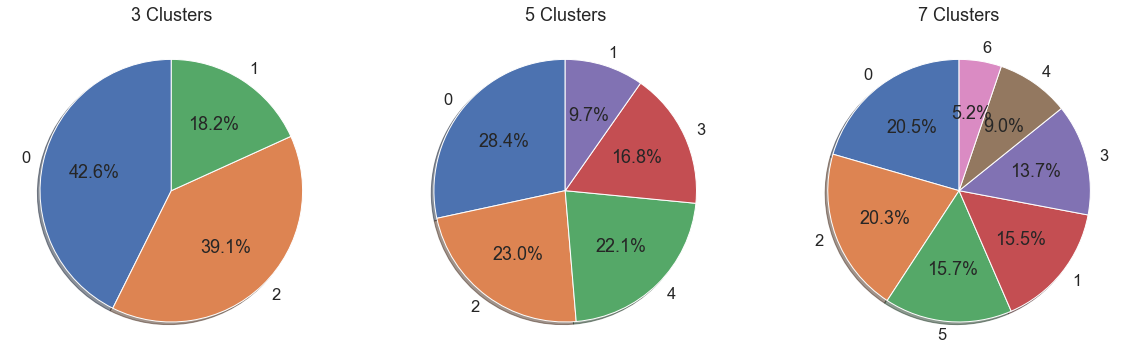

In [44]:
customer_history_df['clusters_3'] = cluster_centers[3]['labels'] 
customer_history_df['clusters_5'] = cluster_centers[5]['labels']
customer_history_df['clusters_7'] = cluster_centers[7]['labels']
display(customer_history_df.head())

fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = customer_history_df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')
f1 = fig.add_subplot(132)
market = customer_history_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')
f1 = fig.add_subplot(133)
market = customer_history_df.clusters_7.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('7 Clusters')
plt.show()

### How the summary of customer in each group is varying

In [45]:
x_data = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
cutoff_quantile = 95

for n_clusters in range(3,K_best+1,2):
    cl = 'clusters_' + str(n_clusters)
    for fild in range(0, 3):
        field_to_plot = features[fild]        
        y_data = list()
        ymax = 0
        for i in np.arange(0,n_clusters):
            y0 = customer_history_df[customer_history_df[cl]==i][field_to_plot].values
            y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
            if ymax < max(y0): ymax = max(y0)
            y_data.insert(i, y0)

        traces = []

        for xd, yd, cls in zip(x_data[:n_clusters], y_data, colors[:n_clusters]):
                traces.append(go.Box(y=yd, name=xd, boxpoints=False, jitter=0.5, whiskerwidth=0.2, fillcolor=cls,
                    marker=dict( size=1, ),
                    line=dict(width=1),
                ))

        layout = go.Layout(
            title='Difference in {} with {} Clusters and {:1.2f} Score'.\
            format(field_to_plot, n_clusters, cluster_centers[n_clusters]['silhouette_score']),
            yaxis=dict( autorange=True, showgrid=True, zeroline=True,
                dtick = int(ymax/10),
                gridcolor='black', gridwidth=0.1, zerolinecolor='rgb(255, 255, 255)', zerolinewidth=2, ),
            margin=dict(l=40, r=30, b=50, t=50, ),
            paper_bgcolor='white',
            plot_bgcolor='white',
            showlegend=False
        )

        fig = go.Figure(data=traces, layout=layout)
        py.offline.iplot(fig)

## Market Basket Analysis with Association Rule-Mining

The market basket analysis is a form of data mining that is often used to uncover purchase patterns in any market or retail setting, the objective of market basket analysis is to observe and understand the target consumer's behavior by  determining the relationships between the items that people often buy. For example, the people who like to buy tea also buy honey often. Market analysis will quantitatively establish that there is a relationship between honey and tea. the same thing can be said for bread, butter and jam. 

#### How does the market basket analysis work?

the market basket analysis is made in reference to Association
rule mining, for example, the IF{} and THEN{} construct. in a 
easy to understand example, IF{} a customer buys bread, THEN{}
he/she is likely to buy butter as well.

following the association rules: it will look like this
{Bread} -> {Butter}

Here are some terms to familiarize yourself with Market basket
analysis.

#### Antecedent: 
the items or itemsets that are found within the 
data are called Antecedets, in simplier words, the Antecedents
are the IF{} component, as can be seen in the association rule
above

#### Consequent: 
A Consequent is a item of a set of items that are
found in combination with the antecedent, while the Antecedent
is the IF{} component, the Consequent will be the THEN{}
component.



#### Build Transaction Dataset
In order to perform our data in these algorithms, we must first turn them into a sales event table where each product sold will be represented by a column, having its value 1 for when it was sold in that event or zero when not

In [47]:
items = list(cs_df.Description.unique())
grouped = cs_df.groupby('InvoiceNo')
transaction_level = grouped.aggregate(lambda x: tuple(x)).reset_index()[['InvoiceNo','Description']]
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
transaction_df = pd.DataFrame(new)

#### Prune Dataset for frequently purchased items

In [48]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, 
                  start_item = None, end_item = None, TopCols = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns={item_count.columns[0]:'item_name',
                               item_count.columns[1]:'item_count'}, inplace=True)
    if TopCols: 
        input_df['total_items'] = input_df[TopCols].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[TopCols], item_count[item_count.item_name.isin(TopCols)]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]
    else:
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]

We use the second option of pruning, by the Top 15th products in sales events.

In [51]:
output_df, item_counts = prune_dataset(input_df=transaction_df, length_trans=2,start_item = 0, end_item = 15)
print('Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): {:.2f}'.format(AmoutSum[Top15ev].sum()))
print('Number of Sales Events:', output_df.shape[0])
print('Number of Products:', output_df.shape[1])

item_counts

Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): 778377.21
Number of Sales Events: 4664
Number of Products: 15


item_name  item_count
0   WHITE HANGING HEART T-LIGHT HOLDER        1978
1             REGENCY CAKESTAND 3 TIER        1703
2              JUMBO BAG RED RETROSPOT        1600
3                        PARTY BUNTING        1379
4        ASSORTED COLOUR BIRD ORNAMENT        1375
5              LUNCH BAG RED RETROSPOT        1289
6    SET OF 3 CAKE TINS PANTRY DESIGN         1146
7                              POSTAGE        1099
8             JUMBO BAG VINTAGE DOILY         1080
9              LUNCH BAG  BLACK SKULL.        1052
10              LUNCH BAG SUKI DESIGN         1043
11                      POPCORN HOLDER        1035
12     PACK OF 72 RETROSPOT CAKE CASES        1029
13                      SPOTTY BUNTING        1009
14            LUNCH BAG VINTAGE DOILY         1006

#### Association Rule Mining with FP Growth

##### Orange Table Data Structure

In [61]:
input_assoc_rules = output_df
# Defined the data domain by specifying each variable as a DiscreteVariable having values as (0, 1)
domain_transac = Domain([DiscreteVariable.make(name=item,values=['0', '1']) \
                         for item in input_assoc_rules.columns])

# Then using this domain, we created our Table structure for our data
data_tran = Orange.data.Table.from_numpy(domain=domain_transac,  
                                         X=input_assoc_rules.to_numpy(),Y= None)

# Coding our input so that the entire domain is represented as binary variables
data_tran_en, mapping = OneHot.encode(data_tran, include_class=True)

##### Creating our rules
We need to specify two pieces of information for generating our rules: support and confidence.

In [62]:
support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*support))
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_en, support))
print('Items Set Size:', len(itemsets))

num of required transactions =  46
Items Set Size: 663273


In [63]:
confidence = 0.6
rules_df = pd.DataFrame()
if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_tran, mapping)}
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]            
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")

Raw rules data frame of 25247 rules generated


##### Explore The Association Rule Created

Let's see what we get in the first 5 rules with highest confidence:

In [64]:
dw = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 100
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['confidence', 'support', 'lift'],
                                                   ascending=False)).head()

consequent  \
20   JUMBO BAG VINTAGE DOILY    
133  LUNCH BAG VINTAGE DOILY    
134  LUNCH BAG VINTAGE DOILY    
131  LUNCH BAG VINTAGE DOILY    
21   JUMBO BAG VINTAGE DOILY    

                                                                                             antecedent  \
20                           JUMBO BAG RED RETROSPOT, LUNCH BAG RED RETROSPOT, LUNCH BAG VINTAGE DOILY    
133  LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG  BLACK SKULL., LUNCH BAG SUKI DESIGN    
134                           LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG SUKI DESIGN    
131                          LUNCH BAG RED RETROSPOT, JUMBO BAG VINTAGE DOILY , LUNCH BAG  BLACK SKULL.   
21                            JUMBO BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN , LUNCH BAG VINTAGE DOILY    

     support  confidence      lift  
20        60    0.909091  4.520256  
133       49    0.890909  4.596460  
134       48    0.888889  4.586037  
131       48    0.872727  4.502655  
21        48    0.872727  4.339446

5 Highest Support

In [65]:
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['support', 'confidence', 'lift'],
                                                   ascending=False)).head()

consequent  \
123  LUNCH BAG VINTAGE DOILY    
28   JUMBO BAG VINTAGE DOILY    
92    LUNCH BAG RED RETROSPOT   
77    LUNCH BAG RED RETROSPOT   
4     JUMBO BAG RED RETROSPOT   

                                            antecedent  support  confidence  \
123  JUMBO BAG VINTAGE DOILY , LUNCH BAG RED RETROSPOT      154    0.777778   
28   LUNCH BAG VINTAGE DOILY , JUMBO BAG RED RETROSPOT      153    0.805263   
92    LUNCH BAG VINTAGE DOILY , LUNCH BAG SUKI DESIGN       149    0.668161   
77     LUNCH BAG  BLACK SKULL., LUNCH BAG SUKI DESIGN       142    0.601695   
4    JUMBO BAG VINTAGE DOILY , LUNCH BAG RED RETROSPOT      138    0.696970   

         lift  
123  4.012783  
28   4.003995  
92   2.672646  
77   2.406780  
4    2.688723

In [66]:
rules_df.lift.apply(lambda x: 'Greater Than One' if x > 1 else 'One' \
                           if x == 0 else 'Less Than One').value_counts()

Greater Than One    25247
Name: lift, dtype: int64

In [68]:
pd.options.display.max_colwidth = dw

### Conclusion

in order to understand the output, we need to familiarize
ourselves with the following terms.

Support: the support is an indication of how much an itemset
appears in the database

Confidence:Confidence is an indication of how often the rule
has been found to be true. It is a measure of the times the 
number of times a rule is found to exist in the dataset.

Lift:lift of the rule is defined as the ratio of observed support
to the support expected in the case the elements of the rule were 
independent.

{insert screenshot of first 5 rules with highest confidence}

as we can see in the figure above, they have a high value
of confidence, this means that those itemsets are proven with a
high probability score of being bought together.

{insert screenshot of first 5 with the highest support}

in the figure above, we can see the itemsets that 
correspond and appears most in the dataset. this means that 
these are the most bought item combination that exists within
the entire dataset

in conclusion, in the entirety of the dataset, we are able to
produce an output that follows a set of rules in regards to 
the support, confidence and lift, there are more factors that 
lead us in this conclusion, however, these three are the most
significant category that helped us produce a reliable output.
The customer segmentation helped us narrow down the data, while
the use of market basket algorithm helped us pinpoint the significant
output.